In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import defaultdict
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder


In [2]:
calender = pd.read_csv(r"C:\Users\ethanwilliams\Desktop\airbnb_ml\Boston\calendar.csv")
listings = pd.read_csv(r"C:\Users\ethanwilliams\Desktop\airbnb_ml\Boston\listings.csv")
reviews = pd.read_csv(r"C:\Users\ethanwilliams\Desktop\airbnb_ml\Boston\reviews.csv")

##  Understanding:

Airbnb is0 a cutomer to customer makerketplace where home owners can rent their homes or rooms within their homes to users of the app. This is generally usefull for people to who are traveling to a different city or towns and would like purchase unique and usually relativliy inexpensive places to accomodate them for the night. 
    

In [88]:
# data Understanding
listings.shape

(3231, 96)

In [4]:
reviews.shape

(68275, 6)

In [5]:
calender.shape

(1308890, 4)

In [6]:
calender

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN
...,...,...,...,...
1308885,14504422,2016-09-10,f,NaN
1308886,14504422,2016-09-09,f,NaN
1308887,14504422,2016-09-08,f,NaN
1308888,14504422,2016-09-07,f,NaN


The Calender dataframe containes 4 columns and over 1308890 rows. It is a largest dataset of the three, and shows the listing id, specific data and their avaibilities while also showing the price point on that date. 

In [94]:
print("availablility: t or f")
print(calender.available.value_counts())
print("")
print("Price")
print(calender.price.describe())

availablility: t or f
f    665853
t    643037
Name: available, dtype: int64

Price
count      643037
unique       1246
top       $150.00
freq        20752
Name: price, dtype: object


In [95]:
def explore(data):
    summaryDF = pd.DataFrame(data.dtypes, columns=['dtypes'])
    summaryDF = summaryDF.reset_index()
    summaryDF['Name'] = summaryDF['index']
    summaryDF['Missing'] = data.isnull().sum().values
    summaryDF['Total'] = data.count().values
    summaryDF['MissPerc'] = (summaryDF['Missing']/data.shape[0])*100
    summaryDF['NumUnique'] = data.nunique().values
    summaryDF['UniqueVals'] = [data[col].unique() for col in data.columns]
    
    


    print(summaryDF.head(30))
explore(calender)

        index  dtypes        Name  Missing    Total   MissPerc  NumUnique  \
0  listing_id   int64  listing_id        0  1308890   0.000000       3585   
1        date  object        date        0  1308890   0.000000        365   
2   available  object   available        0  1308890   0.000000          2   
3       price  object       price   665853   643037  50.871578       1246   

                                          UniqueVals  
0  [12147973, 3075044, 6976, 1436513, 7651065, 12...  
1  [2017-09-05, 2017-09-04, 2017-09-03, 2017-09-0...  
2                                             [f, t]  
3  [nan, $65.00, $75.00, $79.00, $100.00, $125.00...  


The Calender data set is fairly clean, however price should be a float value and date should be in a datetime format. This will be something we can engineering during our preperation process. It is nice to see no missing data in the availability feature, however it looks like we are missing almost 50% of our price datapoints. I wonder why this could be? maybe house prices don't show during false availability days.


In [104]:
calender.price.value_counts()

$150.00      20752
$65.00       17518
$75.00       16249
$100.00      15499
$200.00      14326
             ...  
$1,154.00        1
$1,191.00        1
$1,045.00        1
$1,148.00        1
$1,030.00        1
Name: price, Length: 1246, dtype: int64

In [ ]:
drill_down = calender[['price','available']]
f_values = drill_down[drill_down.available == 'f']
t_values = drill_down[drill_down.available == 't']
print(f_values.price)
print("")
print(t_values)

Yup, from the looks of it all 'f' values do not have price listed and all 't' values do have the price in the listings. This makes sense. 

In [115]:
print(len(listings.columns))

96


In [9]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


In [116]:
explore(listings)

                    index  dtypes                   Name  Missing  Total  \
0                      id   int32                     id        0   3231   
1             listing_url  object            listing_url        0   3231   
2               scrape_id   int64              scrape_id        0   3231   
3            last_scraped  object           last_scraped        0   3231   
4                    name  object                   name        0   3231   
5                 summary  object                summary      140   3091   
6                   space  object                  space      892   2339   
7             description  object            description        0   3231   
8     experiences_offered  object    experiences_offered        0   3231   
9   neighborhood_overview  object  neighborhood_overview     1225   2006   
10                  notes  object                  notes     1756   1475   
11                transit  object                transit     1122   2109   
12          

# data preperation


In [11]:
listings = listings.dropna(subset=['id',"price"], axis=0)
listings['price'] = listings['price'].map(lambda x: x.lstrip('$'))
listings['price'] = listings['price'].replace(',','', regex=True)
listings['id'] = listings['id'].astype(int)
listings['price'] = listings['price'].astype(float)

I need to dorp the NaN values within the id and price features as NaN's are un-important for what I want to know, plus I will need ro remove them if I am to change the dtypes of the price features. I will also need to stip out the $ before I can change the dtypes, doing this is a nessessity if I am going to do any inferential analysis. 

Btw the reason why I decided to drop the NaN within the price feature instead of substituting it with new values is becuase the feautres that coorelate to this price are massivly varied and can be entirly subjective to the owner of the posting. This means the price immputating new price points could skew the accuracy of my results. Plus teh dataset is still large enough without the NaN values for good inferenses.

# Questions 1: 
## How does price change over time?


In [12]:
calender_date = calender[['date','available','listing_id']]
listings_price = listings[['price']]
df_time_query = pd.concat([calender_date, listings_price], axis=1)

In [13]:
print(df_time_query.sort_values(by=['date'], ascending=False))

               date available  listing_id  price
0        2017-09-05         f    12147973  250.0
437528   2017-09-05         f      901914    NaN
441480   2017-09-05         t     1425973    NaN
441146   2017-09-05         f     9094794    NaN
440555   2017-09-05         t    14489201    NaN
...             ...       ...         ...    ...
416099   2016-09-06         f     8753913    NaN
416464   2016-09-06         f     9949819    NaN
416829   2016-09-06         f     2495047    NaN
417194   2016-09-06         f     9853959    NaN
1308889  2016-09-06         f    14504422    NaN

[1308890 rows x 4 columns]


In [14]:
df_time_query = df_time_query.dropna(subset=['listing_id',"price"], axis=0)
df_time_query

,date,available,listing_id,price
0,2017-09-05,f,12147973,250.0
1,2017-09-04,f,12147973,65.0
2,2017-09-03,f,12147973,65.0
3,2017-09-02,f,12147973,75.0
4,2017-09-01,f,12147973,79.0
...,...,...,...,...
3580,2016-11-14,t,849408,69.0
3581,2016-11-13,t,849408,150.0
3582,2016-11-12,t,849408,198.0
3583,2016-11-11,t,849408,65.0


In [15]:
df_time_query['listing_id'] = df_time_query['listing_id'].astype(int)
df_time_query['price'] = df_time_query['price'].astype(float)

In [16]:
df_time_query.dtypes

date           object
available      object
listing_id      int32
price         float64
dtype: object

In [17]:
df_time_query.date.describe()

count           3585
unique           365
top       2017-01-14
freq              10
Name: date, dtype: object

In [18]:
df_time_query.shape[0]

3585

In [19]:
df_time_query['price'].describe()

count    3585.000000
mean      173.925802
std       148.331321
min        10.000000
25%        85.000000
50%       150.000000
75%       220.000000
max      4000.000000
Name: price, dtype: float64

In [20]:
df_time_query[df_time_query.available == "t"].count()

date          2276
available     2276
listing_id    2276
price         2276
dtype: int64

In [21]:
df_time_query[df_time_query.available == "f"].count()

date          1309
available     1309
listing_id    1309
price         1309
dtype: int64

In [22]:
not_available_perc = 1309/3585
not_available_perc

0.36513249651324964

In [23]:
df_time_query[df_time_query.date == "2017-09-03"]

,date,available,listing_id,price
2,2017-09-03,f,12147973,65.0
545,2017-09-03,t,3075044,299.0
891,2017-09-03,t,6976,83.0
1280,2017-09-03,f,1436513,695.0
1672,2017-09-03,t,7651065,275.0
2013,2017-09-03,f,12386020,200.0
2192,2017-09-03,t,5706985,600.0
2555,2017-09-03,t,2843445,48.0
2922,2017-09-03,t,753446,45.0
3287,2017-09-03,f,849408,250.0


In [24]:
df_time_query.groupby(['listing_id'])['price'].mean().reset_index().sort_values(by=['price'], ascending=False)

,listing_id,price
9,12386020,228.219178
3,1436513,219.723288
6,5706985,202.435616
1,753446,187.169863
7,7651065,184.673973
0,6976,182.106849
5,3075044,179.646575
8,12147973,131.975342
2,849408,114.630000
4,2843445,98.117808


In [25]:
df_time_query.loc[df_time_query['listing_id'] == 6976].loc[df_time_query['available'] == "f"].count()

date          46
available     46
listing_id    46
price         46
dtype: int64

In [26]:
df_time_query.loc[df_time_query['listing_id'] == 12386020].price.mean()

228.21917808219177

In [27]:
df_time_query[['available','price']]

,available,price
0,f,250.0
1,f,65.0
2,f,65.0
3,f,75.0
4,f,79.0
...,...,...
3580,t,69.0
3581,t,150.0
3582,t,198.0
3583,t,65.0


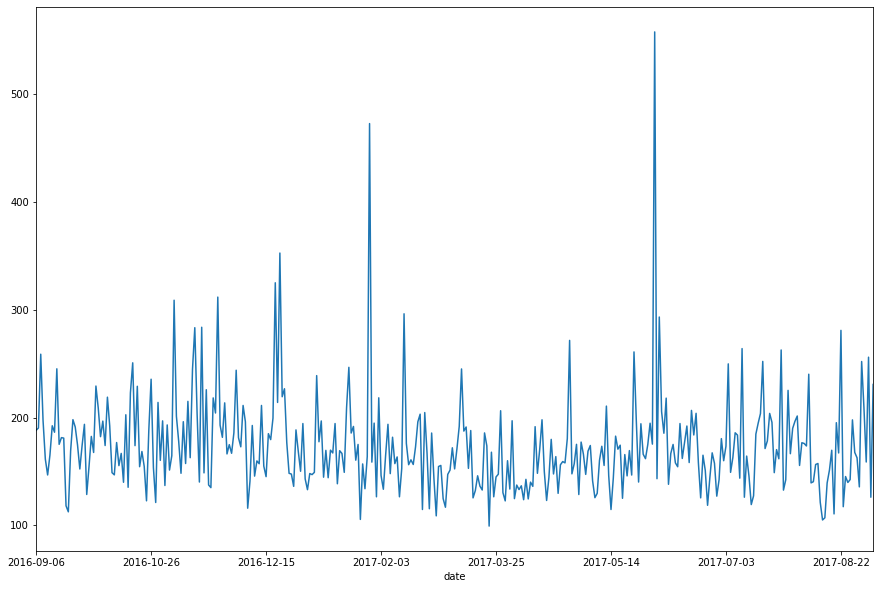

In [28]:
price_timeline = df_time_query.groupby(['date'])['price'].mean()
plt.figure(figsize=(15,10))
price_timeline.plot(kind='line')

In [29]:
price_timeline.tail(50)

date
2017-07-18    203.7
2017-07-19    252.1
2017-07-20    171.2
2017-07-21    178.3
2017-07-22    203.8
2017-07-23    195.5
2017-07-24    148.8
2017-07-25    170.2
2017-07-26    161.7
2017-07-27    262.7
2017-07-28    132.6
2017-07-29    142.2
2017-07-30    225.2
2017-07-31    166.4
2017-08-01    189.9
2017-08-02    196.5
2017-08-03    201.4
2017-08-04    155.5
2017-08-05    176.6
2017-08-06    175.9
2017-08-07    173.6
2017-08-08    240.2
2017-08-09    139.3
2017-08-10    140.4
2017-08-11    156.4
2017-08-12    157.3
2017-08-13    121.2
2017-08-14    104.9
2017-08-15    106.9
2017-08-16    139.3
2017-08-17    151.2
2017-08-18    169.6
2017-08-19    110.5
2017-08-20    195.2
2017-08-21    167.1
2017-08-22    280.9
2017-08-23    117.2
2017-08-24    145.2
2017-08-25    139.7
2017-08-26    142.4
2017-08-27    197.8
2017-08-28    167.6
2017-08-29    162.6
2017-08-30    135.6
2017-08-31    252.0
2017-09-01    209.2
2017-09-02    158.7
2017-09-03    256.0
2017-09-04    126.0
2017-09-05    2

<b>The chart above shows spike at the end of January and at the Beginnning of June. This shows that time of year does have an effect in Boston Airbnb pricing.</b>

In [30]:
df_time_query['month'] = pd.DatetimeIndex(df_time_query['date']).month
df_time_query['day'] = pd.DatetimeIndex(df_time_query['date']).day
df_time_query['year'] = pd.DatetimeIndex(df_time_query['date']).year
df_time_query

,date,available,listing_id,price,month,day,year
0,2017-09-05,f,12147973,250.0,9,5,2017
1,2017-09-04,f,12147973,65.0,9,4,2017
2,2017-09-03,f,12147973,65.0,9,3,2017
3,2017-09-02,f,12147973,75.0,9,2,2017
4,2017-09-01,f,12147973,79.0,9,1,2017
...,...,...,...,...,...,...,...
3580,2016-11-14,t,849408,69.0,11,14,2016
3581,2016-11-13,t,849408,150.0,11,13,2016
3582,2016-11-12,t,849408,198.0,11,12,2016
3583,2016-11-11,t,849408,65.0,11,11,2016


            date available  listing_id  price  month  day  year
184   2016-09-20         f    12147973   65.0      9   20  2016
700   2016-09-20         t     3075044  109.0      9   20  2016
1080  2016-09-20         f        6976   69.0      9   20  2016
1445  2016-09-20         f     1436513  200.0      9   20  2016
1810  2016-09-20         f     7651065  169.0      9   20  2016
2175  2016-09-20         f    12386020  125.0      9   20  2016
2540  2016-09-20         t     5706985  100.0      9   20  2016
2903  2016-09-20         t     2843445   75.0      9   20  2016
3270  2016-09-20         t      753446  100.0      9   20  2016


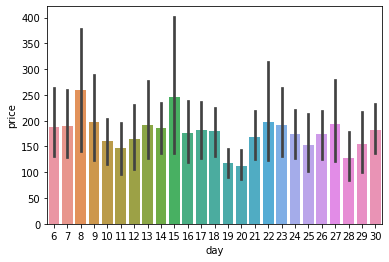

In [31]:
april = df_time_query[df_time_query['month'] == 9 ] 
april_2016 = april[april['year'] == 2016 ]
day = april_2016[april_2016['day'] == 20]
print(day)
#print(april_2016)
#print(april_2016.price.mean())
sns.barplot(data=april_2016, x='day',y='price')

155.82666666666665


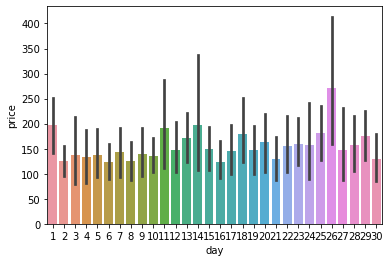

In [32]:
april = df_time_query[df_time_query['month'] == 4 ]
print(april.price.mean())
sns.barplot(data=april, x='day',y='price')

155.38144329896906
194


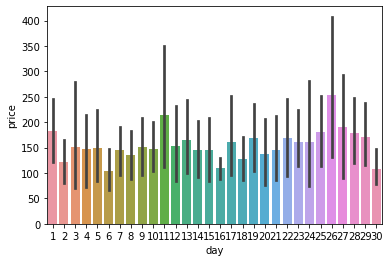

156.64150943396226
106


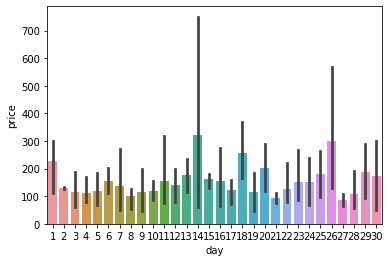

In [33]:
april_not_filled = april.loc[april['available']=='f']
april_filled = april.loc[april['available'] == 't']
sns.barplot(data=april_filled, x='day',y='price')
print(april_filled.price.mean())
print(april_filled.shape[0])
plt.show()
sns.barplot(data=april_not_filled, x='day',y='price')
print(april_not_filled.price.mean())
print(april_not_filled.shape[0])
plt.show()

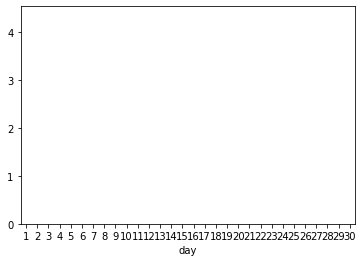

In [34]:
sns.barplot(data=april_filled, x='day',y=april_filled.price.count())

In [35]:
april_filled.listing_id.value_counts()

7651065    30
5706985    30
3075044    30
6976       30
2843445    30
753446     30
1436513    14
Name: listing_id, dtype: int64

In [36]:
april_not_filled.listing_id.value_counts()

12386020    30
12147973    30
849408      30
1436513     16
Name: listing_id, dtype: int64

In [37]:
listings.loc[listings['id'] == 849408].price

9    229.0
Name: price, dtype: float64

187.9225806451613


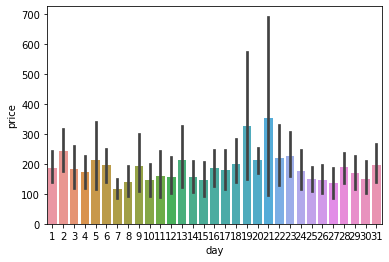

In [38]:
dec = df_time_query[df_time_query['month'] == 12 ]
print(dec.price.mean())
sns.barplot(data=dec, x='day',y='price')

191.70408163265307
98


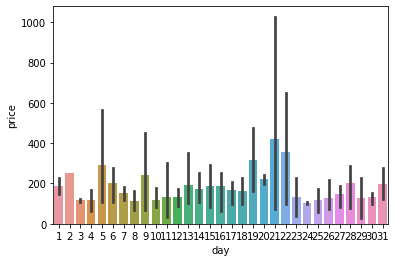

186.1745283018868
212


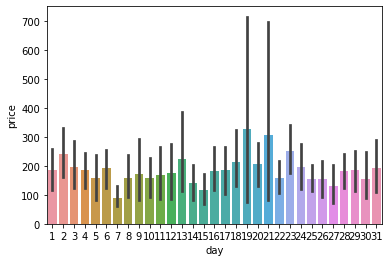

In [39]:
dec_filled = dec.loc[dec['available']=='f']
dec_not_filled = dec.loc[dec['available'] == 't']
sns.barplot(data=dec_filled, x='day',y='price')
print(dec_filled.price.mean())
print(dec_filled.shape[0])
plt.show()
sns.barplot(data=dec_not_filled, x='day',y='price')
print(dec_not_filled.price.mean())
print(dec_not_filled.shape[0])
plt.show()

In [40]:
dec_filled.listing_id.value_counts()

12147973    31
12386020    27
6976        21
1436513     19
Name: listing_id, dtype: int64

In [41]:
dec_not_filled.listing_id.value_counts()

7651065     31
5706985     31
3075044     31
2843445     31
753446      31
849408      31
1436513     12
6976        10
12386020     4
Name: listing_id, dtype: int64

183.5


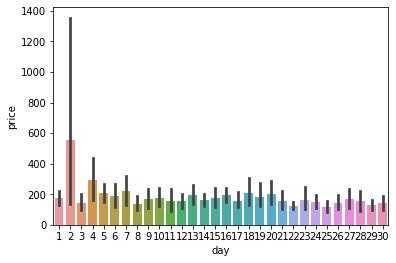

In [42]:
jun = df_time_query[df_time_query['month'] == 6 ]
print(jun.price.mean())
sns.barplot(data=jun, x='day',y='price')

178.3483870967742


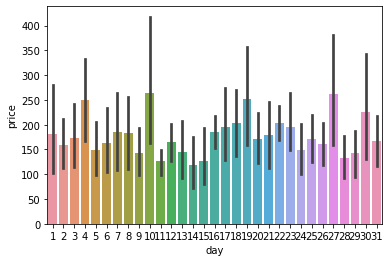

In [43]:
july = df_time_query[df_time_query['month'] == 7]
print(july.price.mean())
sns.barplot(data=july, x='day',y='price')

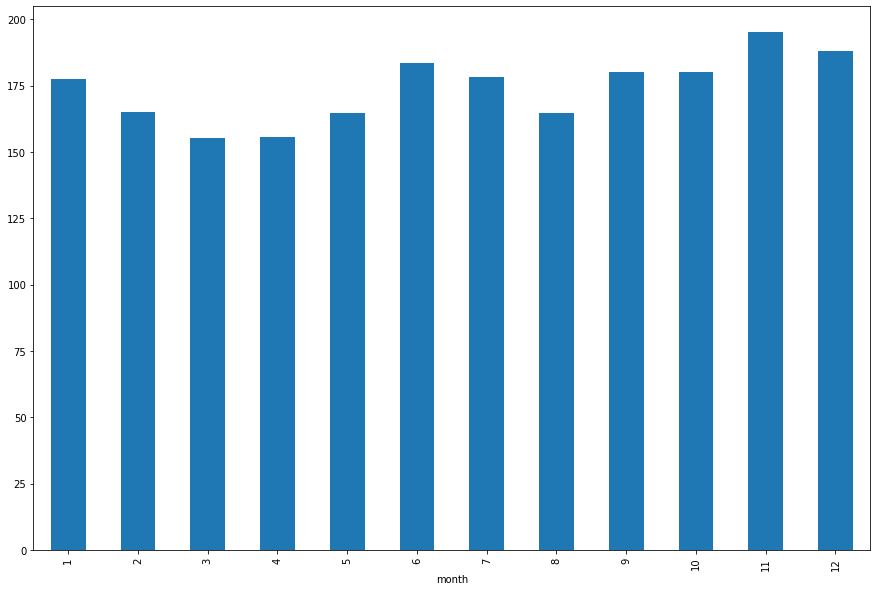

In [44]:
price_month = df_time_query.groupby(['month'])['price'].mean()
plt.figure(figsize=(15,10))
price_month.plot(kind='bar')

<b> looks like November and December have the highest average price listings </b>

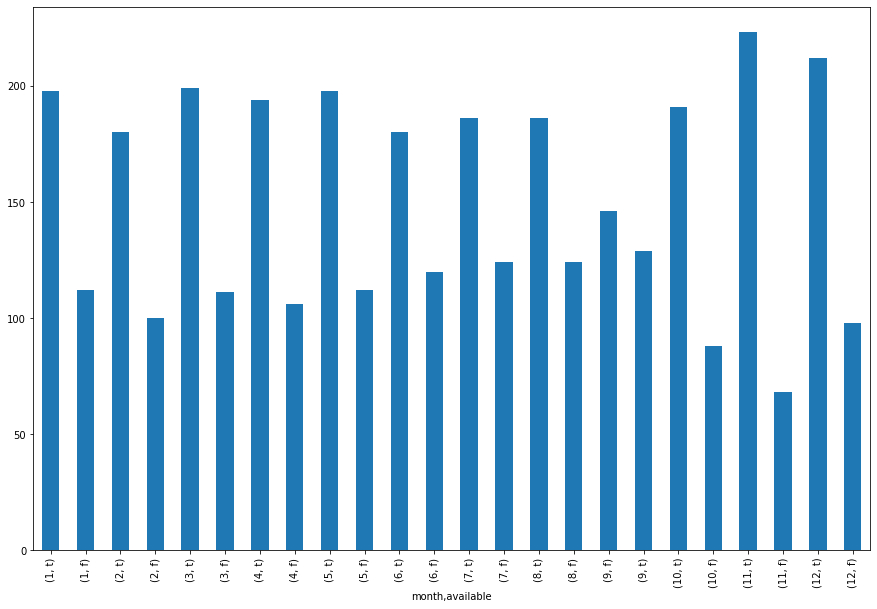

In [45]:
month_availability = df_time_query.groupby(['month'])['available'].value_counts()
plt.figure(figsize=(15,10))
month_availability.plot(kind='bar')


<b>Looks like the prices per unit change overtime. Meaning there is some type of influence on the owner to make this change. I would imagine that holiday's and city wide events spark these changes as vistors increase or decrease as per these events. </b>

# Question 2

# How does property type influence the dataset?

In [46]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

In [47]:
listings.loc[listings['id'] == 6976].weekly_price

2    $395.00
Name: weekly_price, dtype: object

In [48]:
listings.property_type.value_counts()

Apartment          2612
House               562
Condominium         231
Townhouse            54
Bed & Breakfast      41
Loft                 39
Other                17
Boat                 12
Villa                 6
Entire Floor          4
Dorm                  2
Guesthouse            1
Camper/RV             1
Name: property_type, dtype: int64

Most frequently listed property type is "Apartment"

                      price
property_type              
Guesthouse       289.000000
Boat             268.833333
Other            229.941176
Condominium      190.246753
Villa            189.500000
Loft             185.410256
Apartment        181.966692
Townhouse        149.037037
House            131.599644
Bed & Breakfast  129.365854
Entire Floor     122.000000
Dorm              62.500000
Camper/RV         60.000000


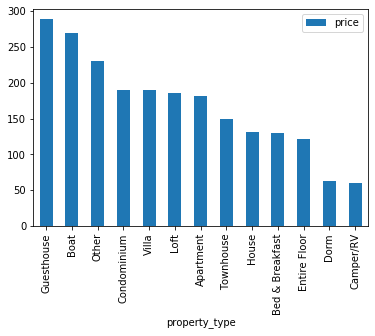

In [49]:
# lets see how value types influence price
property_type_price = listings.groupby(['property_type'])['price'].mean().reset_index().sort_values(by='price', ascending=False)
property_type_price = property_type_price.set_index('property_type')
print(property_type_price)
property_type_price.plot(kind='bar')

Guesthouse on average is listed at the highest prices. 

In [50]:
listings.availability_30[:15]

0      0
1     26
2     19
3      6
4     13
5      5
6     22
7     30
8     12
9     20
10    16
11     6
12     0
13     8
14    11
Name: availability_30, dtype: int64

                 availability_30  booked_perc     price
property_type                                          
Guesthouse             12.000000     0.600000  3.042105
Boat                   22.750000     0.241667  2.829825
Other                  12.705882     0.576471  2.420433
Condominium             6.926407     0.769120  2.002597
Villa                   1.500000     0.950000  1.994737
Loft                    6.307692     0.789744  1.951687
Apartment               8.584609     0.713846  1.915439
Townhouse               8.314815     0.722840  1.568811
House                   9.516014     0.682800  1.385259
Bed & Breakfast         8.829268     0.705691  1.361746
Entire Floor            9.500000     0.683333  1.284211
Dorm                    5.500000     0.816667  0.657895
Camper/RV               4.000000     0.866667  0.631579


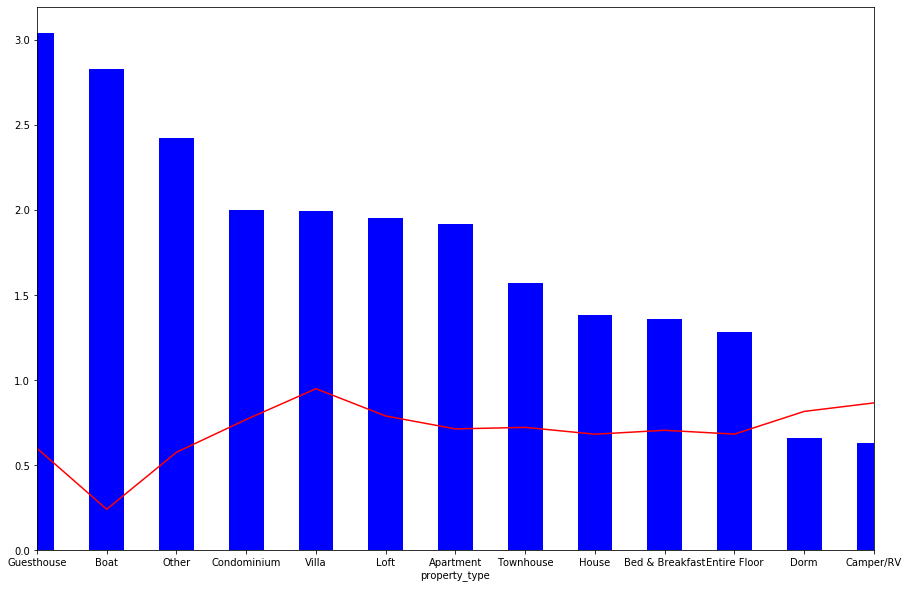

In [51]:
property_type_availability = listings.groupby(['property_type'])['availability_30'].mean().reset_index()
property_type_availability = property_type_availability.set_index('property_type')
property_type_availability['booked_perc'] = property_type_availability.apply(lambda x: (1 - (x/30))) 
property_type_availability['price'] = listings.groupby(['property_type'])['price'].mean()/listings.shape[1]
property_type_availability = property_type_availability.sort_values(by='price', ascending=False)
print(property_type_availability)                                  
                                

plt.figure(figsize=(15,10))
property_type_availability['price'].plot(kind='bar',color='blue')
property_type_availability['booked_perc'].plot(kind='line',color='red')

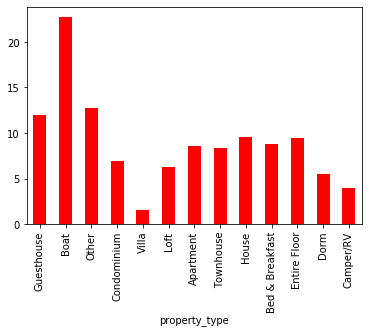

In [52]:
property_type_availability['availability_30'].plot(kind='bar',color='red')

Looks like like the property type influence price, and availablility. Boat's while having the highest average price, also have the hightest avialabily, or in other words are the least booked. While vilas, where the prices are in the 3 quartile range have the highest booking percentage. This can be decribed as a price to commodoties trade off. Where as the fair market value of villa's is reasonable enough for users to pay for and the property meets their standards and quality expectations for travel.

# Question 3

# How does location effect the price

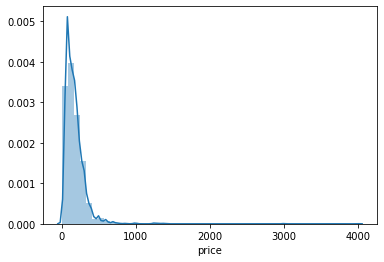

In [53]:
sns.distplot(listings['price'])

In [54]:
listings = listings[listings['price'].between(listings['price'].quantile(.10), listings['price'].quantile(.99))] # without outliers

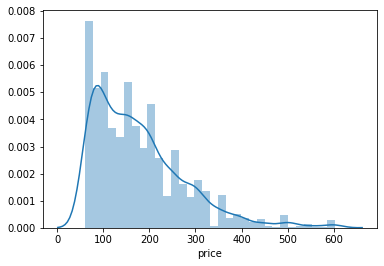

In [55]:
sns.distplot(listings['price'])

In [56]:
location = listings[['city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact','street']]
location

,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,street
0,Boston,MA,02131,Boston,"Boston, MA",US,United States,42.282619,-71.133068,t,"Birch Street, Boston, MA 02131, United States"
1,Boston,MA,02131,Boston,"Boston, MA",US,United States,42.286241,-71.134374,t,"Pinehurst Street, Boston, MA 02131, United States"
2,Boston,MA,02131,Boston,"Boston, MA",US,United States,42.292438,-71.135765,t,"Ardale St., Boston, MA 02131, United States"
3,Boston,MA,NaN,Boston,"Boston, MA",US,United States,42.281106,-71.121021,f,"Boston, MA, United States"
4,Boston,MA,02131,Boston,"Boston, MA",US,United States,42.284512,-71.136258,t,"Durnell Avenue, Boston, MA 02131, United States"
...,...,...,...,...,...,...,...,...,...,...,...
3580,Somerville,MA,02143,Boston,"Somerville, MA",US,United States,42.380968,-71.083795,t,"Washington Street, Somerville, MA 02143, Unite..."
3581,Brookline,MA,02446,Boston,"Brookline, MA",US,United States,42.347503,-71.118336,f,"Freeman Street, Brookline, MA 02446, United St..."
3582,Cambridge,MA,02141,Boston,"Cambridge, MA",US,United States,42.371771,-71.071300,f,"Child Street, Cambridge, MA 02141, United States"
3583,Somerville,MA,02145,Boston,"Somerville, MA",US,United States,42.385226,-71.080923,t,"George St Somerville, Somerville, MA 02145, Un..."


In [57]:
list_price = listings.groupby(['zipcode']).price.mean().reset_index().sort_values(by='price', ascending=False)

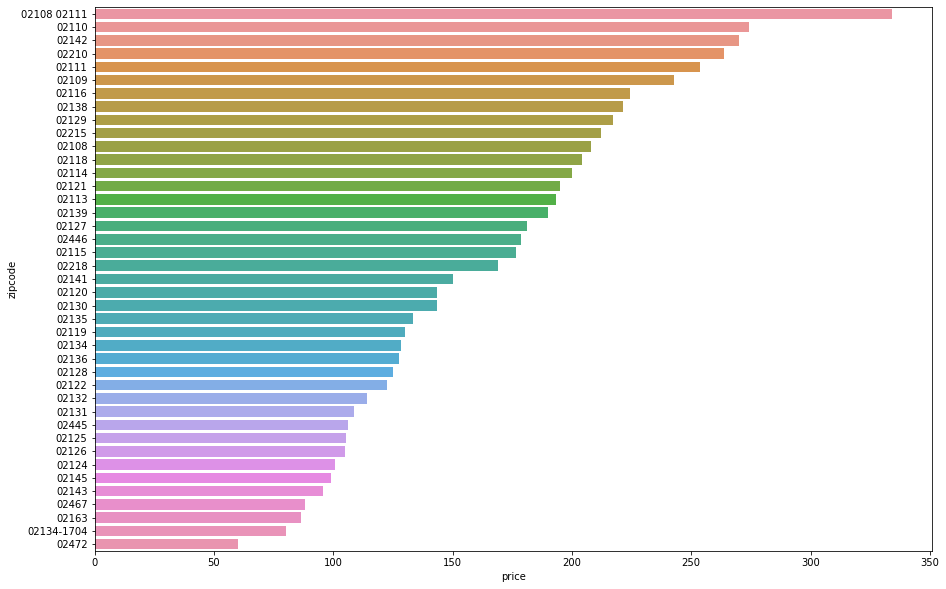

In [58]:
plt.figure(figsize=(15,10))
sns.barplot(data=list_price, x='price', y='zipcode')

Looks like location effects price.

# Feature Selection, Predictive modelings

In [59]:
listings = listings.dropna(subset=["price"], axis=0)
listings.shape

(3231, 95)

In [60]:
quant_cols = listings.select_dtypes(include=['int','float'])
quant_cols.columns

Index(['id', 'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'bathrooms', 'bedrooms', 'beds', 'square_feet', 'price',
       'has_availability', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'jurisdiction_names',
       'reviews_per_month'],
      dtype='object')

In [61]:
quant_null = quant_cols.isnull().sum()/quant_cols.shape[0]
quant = quant_cols.drop(columns=quant_null[quant_null>.2].index.values)
quant.shape

(3231, 7)

In [62]:
qual_cols = listings.select_dtypes(include=['object'])
qual_cols.shape
qual_cols

,listing_url,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,...,extra_people,calendar_updated,calendar_last_scraped,first_review,last_review,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,https://www.airbnb.com/rooms/12147973,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",NaN,"The bus stop is 2 blocks away, and frequent. B...",...,$0.00,2 weeks ago,2016-09-06,NaN,NaN,f,f,moderate,f,f
1,https://www.airbnb.com/rooms/3075044,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,...,$0.00,a week ago,2016-09-06,2014-06-01,2016-08-13,f,t,moderate,f,f
2,https://www.airbnb.com/rooms/6976,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,I am in a scenic part of Boston with a couple ...,"PUBLIC TRANSPORTATION: From the house, quick p...",...,$20.00,5 days ago,2016-09-06,2009-07-19,2016-08-05,f,f,moderate,t,f
3,https://www.airbnb.com/rooms/1436513,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,Please be mindful of the property as it is old...,There are buses that stop right in front of th...,...,$25.00,a week ago,2016-09-06,2016-08-28,2016-08-28,f,f,moderate,f,f
4,https://www.airbnb.com/rooms/7651065,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",I have one roommate who lives on the lower lev...,From Logan Airport and South Station you have...,...,$0.00,2 weeks ago,2016-09-06,2015-08-18,2016-09-01,f,f,flexible,f,f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3580,https://www.airbnb.com/rooms/8373729,2016-09-07,Big cozy room near T,5 min walking to Orange Line subway with 2 sto...,NaN,5 min walking to Orange Line subway with 2 sto...,none,NaN,NaN,NaN,...,$24.00,5 days ago,2016-09-06,2015-09-18,2016-08-27,f,t,strict,f,f
3581,https://www.airbnb.com/rooms/14844274,2016-09-07,BU Apartment DexterPark Bright room,"Most popular apartment in BU, best located in ...",Best location in BU,"Most popular apartment in BU, best located in ...",none,NaN,NaN,"There is green line, BU shuttle in front of th...",...,$0.00,never,2016-09-06,NaN,NaN,f,f,strict,f,f
3582,https://www.airbnb.com/rooms/14585486,2016-09-07,Gorgeous funky apartment,Funky little apartment close to public transpo...,Modern and relaxed space with many facilities ...,Funky little apartment close to public transpo...,none,"Cambridge is a short walk into Boston, and set...","Depending on when you arrive, I can be here to...","Public transport is 5 minuts away, but walking...",...,$0.00,3 weeks ago,2016-09-06,NaN,NaN,f,f,flexible,f,f
3583,https://www.airbnb.com/rooms/14603878,2016-09-07,Great Location; Train and Restaurants,"My place is close to Taco Loco Mexican Grill, ...",NaN,"My place is close to Taco Loco Mexican Grill, ...",none,NaN,NaN,NaN,...,$30.00,today,2016-09-06,2016-08-27,2016-09-04,f,f,strict,f,f


In [63]:
qual_null = qual_cols.isnull().sum()/qual_cols.shape[0]
qual = qual_cols.drop(columns=qual_null[qual_null>.2].index.values)
qual.shape

(3231, 47)

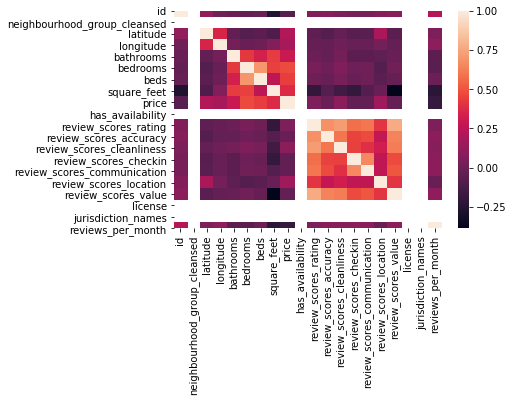

In [64]:
sns.heatmap(quant_cols.corr())

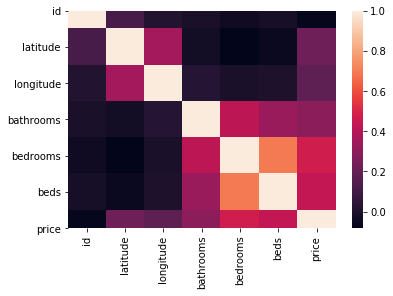

In [65]:
sns.heatmap(quant.corr())

In [66]:
listings

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3580,8373729,https://www.airbnb.com/rooms/8373729,20160906204935,2016-09-07,Big cozy room near T,5 min walking to Orange Line subway with 2 sto...,NaN,5 min walking to Orange Line subway with 2 sto...,none,NaN,...,9.0,f,NaN,NaN,t,strict,f,f,8,0.34
3581,14844274,https://www.airbnb.com/rooms/14844274,20160906204935,2016-09-07,BU Apartment DexterPark Bright room,"Most popular apartment in BU, best located in ...",Best location in BU,"Most popular apartment in BU, best located in ...",none,NaN,...,NaN,f,NaN,NaN,f,strict,f,f,2,NaN
3582,14585486,https://www.airbnb.com/rooms/14585486,20160906204935,2016-09-07,Gorgeous funky apartment,Funky little apartment close to public transpo...,Modern and relaxed space with many facilities ...,Funky little apartment close to public transpo...,none,"Cambridge is a short walk into Boston, and set...",...,NaN,f,NaN,NaN,f,flexible,f,f,1,NaN
3583,14603878,https://www.airbnb.com/rooms/14603878,20160906204935,2016-09-07,Great Location; Train and Restaurants,"My place is close to Taco Loco Mexican Grill, ...",NaN,"My place is close to Taco Loco Mexican Grill, ...",none,NaN,...,7.0,f,NaN,NaN,f,strict,f,f,1,2.00


In [67]:
# looks like bed, square_feet, bedrooms, bathrooms, reviews_scores_locations, reviews_score_cleanliness have strong
# correlation to price. With this said I want to take a look at these values more specifically and check their values
features = ['beds','bedrooms','bathrooms']
X_quant = listings[features] 

print(X_quant.shape)
print(X_quant.isnull().sum())
print(X_quant.dtypes)

(3231, 3)
beds          7
bedrooms     10
bathrooms    10
dtype: int64
beds         float64
bedrooms     float64
bathrooms    float64
dtype: object


In [68]:
listings['property_type'] = listings.property_type.astype(str)

In [69]:
listings.property_type[:300]

0          House
1      Apartment
2      Apartment
3          House
4          House
         ...    
328        House
329    Apartment
330        House
331        House
332    Apartment
Name: property_type, Length: 300, dtype: object

In [70]:
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
listings['property_type_cat'] = labelencoder.fit_transform(listings['property_type'])

In [71]:
listings['property_type_cat'][:300]

0      8
1      0
2      0
3      8
4      8
      ..
328    8
329    0
330    8
331    8
332    0
Name: property_type_cat, Length: 300, dtype: int32

In [72]:
qual_picks = ['street','property_type_cat','room_type','bed_type','extra_people','cancellation_policy','instant_bookable','market',\
              'host_identity_verified','host_is_superhost','host_since']
X_qual = listings[qual_picks].astype(str)
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
X_qual['host_is_super_quant']= labelencoder.fit_transform(X_qual['host_is_superhost'])
X_qual['host_identity_quant']= labelencoder.fit_transform(X_qual['host_identity_verified'])
X_qual['street'] = labelencoder.fit_transform(X_qual['street'])

In [73]:
# Feature Engineering - Editing Nan Values out
#X_quant[X_quant.beds.isnull()]
print(listings[listings.beds == 1].bedrooms.value_counts())


# 1. For the most part if there is 1 room available, there is also only 1 bed
# and if there is two rooms available, there are 2 beds.
# Going to replace all bed nan values to match the room amount

listings['beds'] = listings["beds"].mask(pd.isnull, listings['bedrooms'])


# 2. For Nan Bedrooms, I will replace them with the same value of beds. If 1 bed, then 1 room.

listings['bedrooms'] = listings["bedrooms"].mask(pd.isnull, listings['beds'])

listings['bathrooms'] = listings["bathrooms"].fillna(listings['bathrooms'].mean())


1.0    1605
0.0     229
2.0      17
4.0       1
Name: bedrooms, dtype: int64


In [74]:
X_quant['bathrooms'].value_counts()

1.0    2504
2.0     443
1.5     167
2.5      55
3.0      16
0.0      13
3.5       9
5.0       5
6.0       4
0.5       3
4.0       2
Name: bathrooms, dtype: int64

In [75]:
X_quant.isnull().mean()

beds         0.002167
bedrooms     0.003095
bathrooms    0.003095
dtype: float64

In [76]:
qual.isnull().sum()/qual.shape[0]

listing_url                         0.000000
last_scraped                        0.000000
name                                0.000000
summary                             0.043330
description                         0.000000
experiences_offered                 0.000000
thumbnail_url                       0.167750
medium_url                          0.167750
picture_url                         0.000000
xl_picture_url                      0.167750
host_url                            0.000000
host_name                           0.000000
host_since                          0.000000
host_location                       0.002786
host_response_time                  0.123182
host_response_rate                  0.123182
host_acceptance_rate                0.123182
host_is_superhost                   0.000000
host_thumbnail_url                  0.000000
host_picture_url                    0.000000
host_neighbourhood                  0.094708
host_verifications                  0.000000
host_has_p

In [77]:
X_qual.isnull().sum()

street                    0
property_type_cat         0
room_type                 0
bed_type                  0
extra_people              0
cancellation_policy       0
instant_bookable          0
market                    0
host_identity_verified    0
host_is_superhost         0
host_since                0
host_is_super_quant       0
host_identity_quant       0
dtype: int64

In [78]:
features = ['bedrooms','bathrooms','beds']
X = listings[features].join(X_qual[['property_type_cat','host_is_super_quant','host_identity_quant','street']])
y = listings['price']
df = X.join(y)

In [79]:
X.head()

,bedrooms,bathrooms,beds,property_type_cat,host_is_super_quant,host_identity_quant,street
0,2.0,1.5,3.0,8,0,0,102
1,1.0,1.0,1.0,0,0,1,815
2,1.0,1.0,1.0,0,1,1,42
3,1.0,1.0,2.0,8,0,0,124
4,1.0,1.5,2.0,8,1,1,335


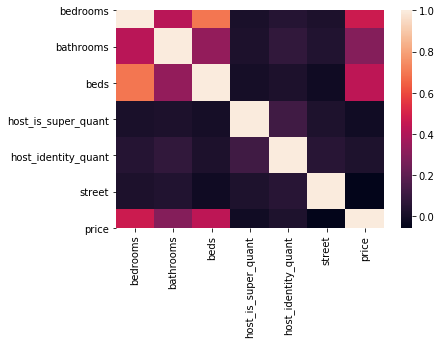

In [80]:
sns.heatmap(df.corr())

In [81]:
X['property_type_cat'] = X.property_type_cat.astype(int)
X['bedrooms'] = X['bedrooms'].astype(int)
X['bathrooms'] = X['bathrooms'].astype(int)

In [82]:
X.dtypes

bedrooms                 int32
bathrooms                int32
beds                   float64
property_type_cat        int32
host_is_super_quant      int32
host_identity_quant      int32
street                   int32
dtype: object

In [83]:
y.shape

(3231,)

In [84]:
X['bathrooms'].value_counts()

1    2681
2     498
3      25
0      16
5       5
6       4
4       2
Name: bathrooms, dtype: int64

In [85]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.20, random_state=32)
model = LinearRegression()
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
test_score = r2_score(y_test, y_test_pred)
test_score

0.2760018341382833

In [87]:
test_score = mean_absolute_error(y_test, y_test_pred)
test_score

66.77687486498803